Si ModuleNotFoundError: No module named 'tqdm' faire !pip install tqdm dans une cellule code

In [15]:
import os
import numpy as np
import joblib
import cv2

import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
CHECKPOINT_DIR = "chekpoints_ORB"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [3]:
UPSCALE_TO = 96
N_FEATURES = 500
VOCAB_SIZE = 300
KMEANS_BATCH = 4096
RANDOM_STATE = 42

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [5]:
x_train_u8 = x_train.astype(np.uint8)
x_test_u8  = x_test.astype(np.uint8)

def preprocess_for_orb(img_u8, upscale_to=96):
    if upscale_to is not None and upscale_to != img_u8.shape[0]:
        img_u8 = cv2.resize(img_u8, (upscale_to, upscale_to), interpolation=cv2.INTER_CUBIC)
    return img_u8
orb = cv2.ORB_create(nfeatures=N_FEATURES)

In [7]:
def extract_orb_desc_from_array(images_u8, upscale_to=96, max_images=None):
    desc_list = []
    valid_idx = []

    n = len(images_u8) if max_images is None else min(len(images_u8), max_images)

    for i in range(n):
        img = preprocess_for_orb(images_u8[i], upscale_to=upscale_to)
        kp, desc = orb.detectAndCompute(img, None)
        if desc is None or len(desc) == 0:
            continue
        desc_list.append(desc)   # (n_kp, 32)
        valid_idx.append(i)

    return desc_list, np.array(valid_idx, dtype=np.int32)


In [8]:
train_desc_list, train_valid_idx = extract_orb_desc_from_array(x_train_u8, upscale_to=UPSCALE_TO)
test_desc_list,  test_valid_idx  = extract_orb_desc_from_array(x_test_u8,  upscale_to=UPSCALE_TO)

y_train_f = y_train[train_valid_idx]
y_test_f  = y_test[test_valid_idx]

print("Train kept:", len(train_desc_list), "/", len(x_train_u8))
print("Test kept :", len(test_desc_list),  "/", len(x_test_u8))

Train kept: 59815 / 60000
Test kept : 9971 / 10000


In [18]:
all_train_desc = np.vstack(train_desc_list).astype(np.float32)  # (N_total_kp, 32)
print("Total train descriptors:", all_train_desc.shape)

kmeans = MiniBatchKMeans(
    n_clusters=VOCAB_SIZE,
    batch_size=KMEANS_BATCH,
    random_state=42,
    n_init="auto"
)

kmeans.fit(all_train_desc)

joblib.dump(kmeans, os.path.join(CHECKPOINT_DIR, "kmeans_vocab_mnist.pkl"))
print("Saved vocab to:", os.path.join(CHECKPOINT_DIR, "kmeans_vocab_mnist.pkl"))


Total train descriptors: (1024077, 32)
Saved vocab to: chekpoints_ORB\kmeans_vocab_mnist.pkl


In [10]:
def bovw_histograms(desc_list, kmeans, vocab_size):
    X = np.zeros((len(desc_list), vocab_size), dtype=np.float32)

    for i, desc in enumerate(desc_list):
        words = kmeans.predict(desc.astype(np.float32))
        hist = np.bincount(words, minlength=vocab_size).astype(np.float32)

        # Normalisation L2 (souvent mieux pour SVM)
        norm = np.linalg.norm(hist) + 1e-12
        X[i] = hist / norm

    return X

X_train = bovw_histograms(train_desc_list, kmeans, VOCAB_SIZE)
X_test  = bovw_histograms(test_desc_list,  kmeans, VOCAB_SIZE)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

X_train: (59815, 300)
X_test : (9971, 300)


In [17]:
svm = LinearSVC(dual="auto", random_state=42)
svm.fit(X_train, y_train_f)

joblib.dump(svm, os.path.join(CHECKPOINT_DIR, "svm_bovw_orb_mnist.pkl"))
print("Saved SVM to:", os.path.join(CHECKPOINT_DIR, "svm_bovw_orb_mnist.pkl"))



Saved SVM to: chekpoints_ORB\svm_bovw_orb_mnist.pkl


In [13]:
y_pred = svm.predict(X_test)

acc = accuracy_score(y_test_f, y_pred)
print("Accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_test_f, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test_f, y_pred))

Accuracy: 0.6373483100992879

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.76      0.69       966
           1       0.79      0.95      0.87      1121
           2       0.55      0.47      0.51      1031
           3       0.67      0.76      0.71      1010
           4       0.56      0.50      0.53       982
           5       0.57      0.58      0.58       892
           6       0.62      0.58      0.60       958
           7       0.62      0.48      0.54      1028
           8       0.64      0.67      0.65       974
           9       0.63      0.58      0.60      1009

    accuracy                           0.64      9971
   macro avg       0.63      0.63      0.63      9971
weighted avg       0.63      0.64      0.63      9971


Confusion matrix:
[[ 732   95   34   13   14   20   14   34    9    1]
 [  32 1068    7    3    1    1    2    7    0    0]
 [ 112   65  486   70   35   30   52   98   54   29]
 [  22    

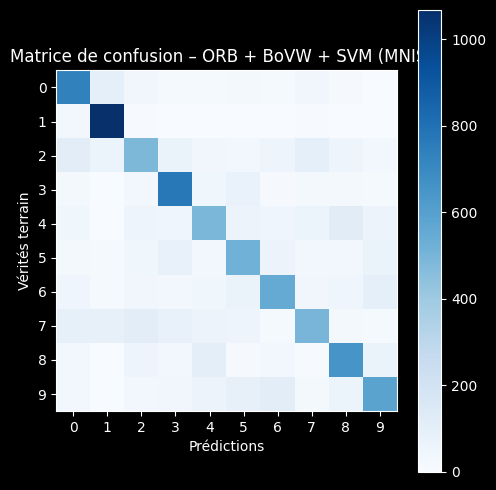

In [16]:
cm = confusion_matrix(y_test_f, y_pred)

plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues")
plt.title("Matrice de confusion – ORB + BoVW + SVM (MNIST)")
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.colorbar()

# MNIST : classes = chiffres 0 à 9
classes = list(range(10))
plt.xticks(classes, classes)
plt.yticks(classes, classes)

plt.tight_layout()
plt.show()

# Conclusion

Dans ce projet, nous avons mis en œuvre une approche de classification d’images basée sur des méthodes de Machine Learning classiques, combinant l’extraction de descripteurs locaux ORB, un modèle Bag of Visual Words et un classifieur SVM à noyau RBF.

Sur le dataset Dogs vs Cats, le modèle atteint une petite accuracy d’environ 69 %. Cette approche repose uniquement sur des motifs locaux et ne capture pas la structure globale des objets, ce qui entraîne certaines confusions entre les deux classes.

Néanmoins, cette méthode présente plusieurs avantages notables : un coût de calcul réduit, une mise en œuvre simple, et une bonne stabilité, avec peu de risque de sur-apprentissage. Elle constitue ainsi une baseline pertinente et explicable, permettant de comparer efficacement les performances des approches Machine Learning classiques et Deep Learning dans le cadre de la classification d’images.